This analysis will be using the Chinook DB to answer some business questions.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import sqlite3
%matplotlib inline

# creates a helper function for returning tables 
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

# creates a helper function for views 
def run_command(c):
    with sqlite3.connect('chinook.db') as conn: 
        conn.isolation_level = None 
        conn.execute(c)
        
#returns a list of all tables and views in the db
def show_tables():
    q = 'SELECT name, type FROM sqlite_master WHERE type IN ("table", "view");'
    return run_query(q)

In [3]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [170]:
#first query finds total_sold by genre
q =(
"SELECT g.name, " 
"sum(il.quantity) total_sold, "
"ROUND((sum(CAST(il.quantity as FLOAT))/"
"(SELECT sum(il.quantity) "
"FROM invoice_line il " 
"INNER JOIN invoice i on i.invoice_id = il.invoice_id "
"WHERE i.billing_country = 'USA') * 100), 2) percent "
"FROM invoice_line il "
"INNER JOIN invoice i ON i.invoice_id = il.invoice_id "
"INNER JOIN track t ON t.track_id = il.track_id " 
"INNER JOIN genre g ON g.genre_id = t.genre_id "
"WHERE i.billing_country = 'USA'"
"GROUP BY g.name " 
"ORDER BY total_sold DESC "
) 

genre_sales_usa = run_query(q)

run_query(q)



,name,total_sold,percent
0,Rock,561,53.38
1,Alternative & Punk,130,12.37
2,Metal,124,11.80
3,R&B/Soul,53,5.04
4,Blues,36,3.43
5,Alternative,35,3.33
6,Latin,22,2.09
7,Pop,22,2.09
8,Hip Hop/Rap,20,1.90
9,Jazz,14,1.33


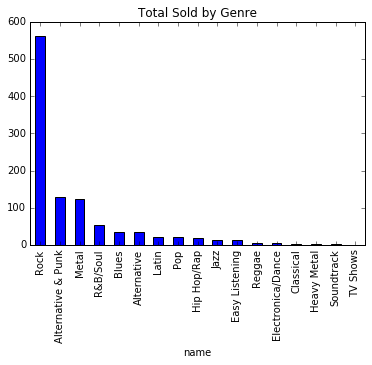

In [167]:
#sets index on original df and then plots
genre_sales_usa.set_index("name",drop=True,inplace=True)
genre_sales_usa["total_sold"].plot.bar(title= "Total Sold by Genre")

Rock outnumbers the rest of the genres at 53% of US sales. The second most bought genre is Alternative Rock at 12.3%.

In [171]:
#query finds total_sales by sale rep
q2 = (
"SELECT "
" e.first_name || ' ' || e.last_name sales_rep, "
" sum(i.total) total_sales, "
"e.hire_date "
"FROM employee e " 
"INNER JOIN customer c ON c.support_rep_id = e.employee_id "
"INNER JOIN invoice i on i.customer_id = c.customer_id "
"GROUP BY e.employee_id"    
)

genre_sales_usa = run_query(q2)

run_query(q2)

,sales_rep,total_sales,hire_date
0,Jane Peacock,1731.51,2017-04-01 00:00:00
1,Margaret Park,1584.00,2017-05-03 00:00:00
2,Steve Johnson,1393.92,2017-10-17 00:00:00


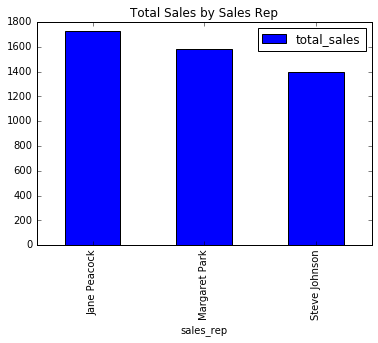

In [172]:
# set index and plot total sales by sale rep
genre_sales_usa.set_index("sales_rep").plot.bar(title="Total Sales by Sales Rep")

Jane Peacock is the highest sales person with a total of $1731.51. The other sales reps are also performing really well. Jane Peacock selling more may be due to her earlier start date at the company.

In [173]:
# query that groups customers by country
q3 = '''
WITH i_totals AS 
(
SELECT 
    cs.customer_id id,
    sum(i.total) total_sales,
    avg(i.total) avg_cs_sale,
    cs.country country
FROM invoice i 
INNER JOIN customer cs ON cs.customer_id = i.customer_id
GROUP BY cs.customer_id 
),

totals_country AS
(
SELECT 
    sum(total_sales) sales,
    AVG(avg_cs_sale) avg_sale,
    country,
    count(id) total_customers,
    CASE 
        WHEN count(id) = 1 THEN "Other"
        ELSE country
    END AS sort
FROM i_totals
GROUP BY country
ORDER BY 1 DESC
)

SELECT 
    sum(sales) total_sales,
    avg(avg_sale) avg_sale,
    sum(total_customers) total_customers,
    sort as country
FROM totals_country
GROUP BY sort 
ORDER BY total_sales DESC
'''

country_sales = run_query(q3)
run_query(q3)

,total_sales,avg_sale,total_customers,country
0,1094.94,7.445071,15,Other
1,1040.49,8.014750,13,USA
2,535.59,7.416238,8,Canada
3,427.68,6.987485,5,Brazil
4,389.07,7.835000,5,France
5,334.62,8.188750,4,Germany
6,273.24,9.377500,2,Czech Republic
7,245.52,8.749583,3,United Kingdom
8,185.13,6.527813,2,Portugal
9,183.15,8.757692,2,India


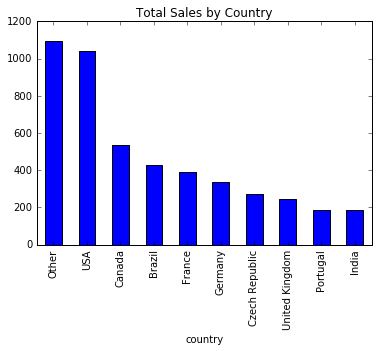

In [147]:
country_sales.set_index("country")["total_sales"].plot.bar( title="Total Sales by Country")

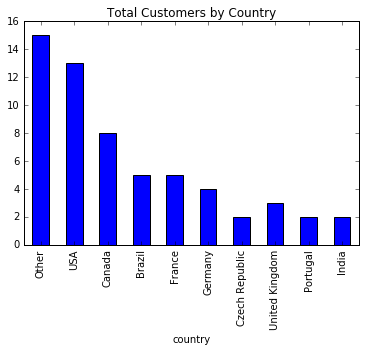

In [162]:
#sets index and plotting total customers
country_sales.set_index("country")["total_customers"].plot.bar(title="Total Customers by Country")

The countries in the category Other had the most sales at 1094. 
The USA followed in second at 1040. 

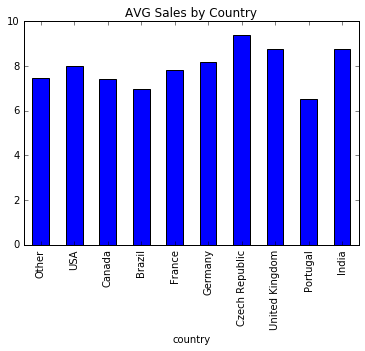

In [165]:
#sets index and plots avg_sale
country_sales.set_index("country")["avg_sale"].plot.bar(title="AVG Sales by Country")

In terms of growth, it may be worthwhile to push for countries where the average sale and customer number is high. For example, the Czech Republic has a low number of customers but a high average sale amount. 

In [ ]:
#create view of tracks not bought
q5 = '''
CREATE VIEW track_nb AS
    SELECT 
        track_id
    FROM track 
    EXCEPT
    SELECT track_id
    FROM invoice_line
'''


run_command(q5)

In [9]:
#checking tables 
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [ ]:
#creates view of albums not bought entirely 
q6='''
CREATE VIEW album_nb AS
    SELECT 
        DISTINCT(album_id) 
    FROM track
    INNER JOIN track_nb ON track_nb.track_id = track.track_id;
'''
run_command(q6)



In [21]:
# view determines album versus track purchases using the albums not purchased view
q7 = '''
CREATE VIEW type_of_buy AS
    SELECT 
        invoice_id,
        t.album_id,
        t.track_id,
        CASE WHEN t.album_id IN (SELECT * FROM album_nb) THEN "Partial Buy"
        ELSE "Full Buy"
        END AS type_of_buy
    FROM invoice_line il
    INNER JOIN track t ON t.track_id = il.track_id
'''
run_command(q7)

In [31]:
#query to count the types of purchases 
q8 = '''
SELECT 
    type_of_buy,
    count(type_of_buy) count,
    (CAST(count(type_of_buy) as float)/4757)*100 percent
FROM type_of_buy
GROUP BY type_of_buy
'''
run_query(q8)

,type_of_buy,count,percent
0,Full Buy,3752,78.873239
1,Partial Buy,1005,21.126761


Most of the purchases are full album ones at 78%. Based of these findings, it makes sense to still purchase full albums from record companies.